In [11]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [19]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
len(all_executions)
executions = all_executions[0:40]
te_s = 0.3
val_s = 0.4

In [20]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Existing_Generation_Full_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_112

In [21]:
ts_in,ts_out =  DataLoading.split_tr_val_te_by_exec(dfs_in,dfs_out,executions,te_s,val_s,False)

In [22]:
d_ft_in, d_ft_out,maxs = DataLoading.concat_and_normalize_split_by_exec(ts_in,ts_out,executions)

In [23]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

# training_loader = DataLoader(train,batch_size=64)
# validation_loader = DataLoader(train,batch_size=64)

In [24]:
i=0
nbs_hidden = [3]
dors = [0]#,0.05,0.1]#,0.05]
relu_outs=[False]

batch_sizes = [32,64,128,256]
learning_rates = [0.0025*4**i for i in range(-1,3,1)]
nbs_e = [4,8,12,16,20] # ,8]
negative_penalisations = [0]


results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w_split_by_exec_test"

hp_sets = ((nb_h,dor,relu_out,bs,lr,nb_e,np) for nb_h in nbs_hidden for dor in dors for relu_out in relu_outs for bs in batch_sizes for lr in learning_rates for nb_e in nbs_e for np in negative_penalisations)


for hp_set in hp_sets:
    print(hp_set)
    nb_hidden,dor,relu_out,bs,lr,nb_e,np = hp_set[0],hp_set[1],hp_set[2],hp_set[3],hp_set[4],hp_set[5],hp_set[6]
    
    #Create training and validation loaders based on batch size
    training_loader = DataLoader(train,batch_size=bs)
    validation_loader = DataLoader(train,batch_size=bs)
    
    #Initialize loss functions
    loss_fn = NN_classes.create_loss_fn(penalize_negative=np)
    loss_t_mse = torch.nn.MSELoss()
    
    #Create model based on hyperparameter set
    m = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor,relu_out=relu_out)
    #Create model name for saving and loading
    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro"
    #Create optimizer based on learning rate 
    optimizer = torch.optim.Adam(m.parameters(), lr=lr)
    #Train the actual model 
    t_start_train = time.perf_counter()
    train_loss_1 = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)[0]
    t_stop_train = time.perf_counter()
    
    #In the following loop, we retreive the models from saved locations and calculate losses 
    for mt in ["min_val","all_epochs"]:
        t_start_eval = time.perf_counter()
        path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"
        
        #Retreive model state and set to evaluation mode
        m.load_state_dict(torch.load(path))
        m.eval()
        
        #Calculate losses
        test_predictions = m(d_ft_in["test"].float())
        test_loss = loss_fn(test_predictions.squeeze(),d_ft_out["test"])
        test_loss_t_mse = loss_t_mse(test_predictions.squeeze(),d_ft_out["test"])


        train_predictions = m(d_ft_in["train"].float())
        train_loss = loss_fn(train_predictions.squeeze(),d_ft_out["train"])
        train_loss_t_mse = loss_t_mse(train_predictions.squeeze(),d_ft_out["train"])


        validation_prediction = m(d_ft_in["val"].float())
        validation_loss = loss_fn(validation_prediction.squeeze(),d_ft_out["val"])
        validation_loss_t_mse = loss_t_mse(validation_prediction.squeeze(),d_ft_out["val"])
        t_stop_eval = time.perf_counter()
        
        
        #Calculate some calculation times 
        t_train = t_stop_train - t_start_train
        t_eval = t_stop_eval - t_start_eval
        
        #Finally, save all desired values in a dataframe
        r = pd.DataFrame({"Model_type": nb_hidden,
                        "Dor": dor,
                        "Relu_out": relu_out,
                        "Batch_size": bs,
                        "Lr":lr,
                        "Epochs": nb_e,
                        "Np": np,
                        "Min_val":mt,
                        "Tr_l":train_loss.item(),
                        "Te_l":test_loss.item(),
                        "V_l": validation_loss.item(),
                        "Tr_l_t_mse":train_loss_t_mse.item(),
                        "Te_l_t_mse":test_loss_t_mse.item(),
                        "V_l_t_mse": validation_loss_t_mse.item(),
                        "Tr_l_ret": train_loss_1.item(),
                        "Train_time": t_train,
                        "Eval_time": t_eval
                         }
                        ,index = [i])
        i+=1
        results = pd.concat([results,r])


        


(3, 0, False, 32, 0.000625, 4, 0)
EPOCH 1:
LOSS train 3.437943589944384e-05 valid 3.590268079278758e-06
EPOCH 2:
LOSS train 3.2592551889781663e-06 valid 3.3078749765991233e-06
EPOCH 3:
LOSS train 3.565684311881058e-06 valid 3.524519797792891e-06
EPOCH 4:
LOSS train 3.0639243361929636e-06 valid 3.302867071397486e-06
(3, 0, False, 32, 0.000625, 8, 0)
EPOCH 1:
LOSS train 6.198949386649581e-06 valid 2.6007833184849005e-06
EPOCH 2:
LOSS train 2.3826297971388616e-06 valid 2.57300462180865e-06
EPOCH 3:
LOSS train 1.8333557272393564e-06 valid 3.5989144180348376e-06
EPOCH 4:
LOSS train 1.4927182001834666e-06 valid 4.06504159400356e-06
EPOCH 5:
LOSS train 1.6193706382193982e-06 valid 1.1553961485333275e-06
EPOCH 6:
LOSS train 9.497186442737839e-07 valid 6.276806630012288e-07
EPOCH 7:
LOSS train 5.124843583482235e-07 valid 3.141404931739089e-07
EPOCH 8:
LOSS train 5.549709829581317e-07 valid 2.4751687988100457e-07
(3, 0, False, 32, 0.000625, 12, 0)
EPOCH 1:
LOSS train 4.410360264498181e-05 valid 

LOSS train 9.48191194896161e-07 valid 4.127615511606564e-07
EPOCH 13:
LOSS train 9.753110576509323e-07 valid 2.945245114460704e-07
EPOCH 14:
LOSS train 4.3437108233498517e-07 valid 3.2630424584567663e-07
EPOCH 15:
LOSS train 5.279065255167725e-07 valid 2.672516643542622e-07
EPOCH 16:
LOSS train 4.982401421043416e-07 valid 3.933860455163085e-07
EPOCH 17:
LOSS train 4.923975046602423e-07 valid 1.3977424941913341e-06
EPOCH 18:
LOSS train 4.863409100035873e-07 valid 6.310680760179821e-07
EPOCH 19:
LOSS train 4.1785557180141047e-07 valid 5.613950406768708e-07
EPOCH 20:
LOSS train 5.764286287415084e-07 valid 1.755844436956977e-06
(3, 0, False, 32, 0.01, 4, 0)
EPOCH 1:
LOSS train 0.0006561657048481593 valid 1.930614189404878e-06
EPOCH 2:
LOSS train 2.8723225743693283e-06 valid 2.92352319775091e-06
EPOCH 3:
LOSS train 3.144929216817235e-06 valid 2.317655116712558e-06
EPOCH 4:
LOSS train 1.8690081489834719e-06 valid 2.5678359634184744e-06
(3, 0, False, 32, 0.01, 8, 0)
EPOCH 1:
LOSS train 0.0005

LOSS train 1.099626035778546e-05 valid 6.514678261737572e-06
EPOCH 5:
LOSS train 0.00012558023718018305 valid 5.120613786857575e-05
EPOCH 6:
LOSS train 3.273213401915031e-05 valid 7.643149001523852e-05
EPOCH 7:
LOSS train 3.481845578228119e-05 valid 7.467370596714318e-05
EPOCH 8:
LOSS train 3.506456964732859e-05 valid 7.487300172215328e-05
EPOCH 9:
LOSS train 3.817638662732544e-05 valid 9.993365529226139e-05
EPOCH 10:
LOSS train 4.120671594639822e-05 valid 0.00010102495434693992
EPOCH 11:
LOSS train 4.126285791176636e-05 valid 0.0001010369960567914
EPOCH 12:
LOSS train 4.126350181714824e-05 valid 0.00010103725071530789
EPOCH 13:
LOSS train 4.1263508091099834e-05 valid 0.0001010372579912655
EPOCH 14:
LOSS train 4.126350853845411e-05 valid 0.00010103719250764698
EPOCH 15:
LOSS train 4.126350925380724e-05 valid 0.00010103719978360459
EPOCH 16:
LOSS train 4.126351298328143e-05 valid 0.0001010373089229688
EPOCH 17:
LOSS train 4.126351331538213e-05 valid 0.0001010373089229688
EPOCH 18:
LOSS 

LOSS train 6.948441738421061e-07 valid 9.226783959093154e-07
EPOCH 12:
LOSS train 6.109009445874836e-07 valid 2.486009634594666e-06
EPOCH 13:
LOSS train 1.3170675335754142e-06 valid 2.0634392683405167e-07
EPOCH 14:
LOSS train 7.93012991372831e-07 valid 3.5506225231074495e-06
EPOCH 15:
LOSS train 1.0562172777366769e-06 valid 3.8604680412390735e-06
EPOCH 16:
LOSS train 5.501740668969674e-07 valid 5.174778834771132e-06
(3, 0, False, 64, 0.0025, 20, 0)
EPOCH 1:
LOSS train 0.0001429481740497359 valid 2.2059141429053852e-06
EPOCH 2:
LOSS train 1.8196627443552425e-06 valid 2.2962292405281914e-06
EPOCH 3:
LOSS train 1.8948863390185207e-06 valid 2.561274186518858e-06
EPOCH 4:
LOSS train 2.6656884337118283e-06 valid 1.74279546172329e-06
EPOCH 5:
LOSS train 2.388558767189186e-06 valid 5.663681349687977e-06
EPOCH 6:
LOSS train 2.1834563086885093e-06 valid 1.7010822830343386e-06
EPOCH 7:
LOSS train 1.852251730735632e-06 valid 1.0137838444279623e-06
EPOCH 8:
LOSS train 2.952956145011066e-06 valid 1.

LOSS train 4.5135480702104845e-06 valid 7.325205388042377e-06
EPOCH 4:
LOSS train 1.328289155922232e-05 valid 2.4686230972292833e-05
EPOCH 5:
LOSS train 2.155015469744068e-05 valid 2.9386797905317508e-05
EPOCH 6:
LOSS train 1.4187817910517843e-05 valid 5.691090336767957e-06
EPOCH 7:
LOSS train 7.81693071840017e-06 valid 4.646525212592678e-06
EPOCH 8:
LOSS train 4.965380928460429e-06 valid 3.5615782962850062e-06
EPOCH 9:
LOSS train 4.034509374001724e-06 valid 4.3622985685942695e-06
EPOCH 10:
LOSS train 0.00010863254050953756 valid 5.567272091866471e-05
EPOCH 11:
LOSS train 5.2710797438949436e-05 valid 0.00010736300464486703
EPOCH 12:
LOSS train 3.887463144655128e-05 valid 5.588846033788286e-05
EPOCH 13:
LOSS train 4.357016627390022e-05 valid 5.534152660402469e-05
EPOCH 14:
LOSS train 3.149655032916716e-05 valid 5.078900358057581e-05
EPOCH 15:
LOSS train 2.9688265029306956e-05 valid 6.145607767393813e-05
EPOCH 16:
LOSS train 2.9382294365729974e-05 valid 7.529980211984366e-05
(3, 0, False

LOSS train 2.524407400465718e-06 valid 3.182419959557592e-06
EPOCH 7:
LOSS train 2.2041375744170353e-06 valid 3.0335365863720654e-06
EPOCH 8:
LOSS train 1.6656585298237103e-06 valid 1.7525734392620507e-06
EPOCH 9:
LOSS train 1.8181619173670037e-06 valid 1.2325422176218126e-06
EPOCH 10:
LOSS train 2.6277597426279025e-06 valid 4.0033737604971975e-06
EPOCH 11:
LOSS train 1.4952803255776439e-06 valid 2.2646900106337853e-06
EPOCH 12:
LOSS train 1.6114690684626392e-06 valid 2.3885793325462146e-06
(3, 0, False, 128, 0.0025, 16, 0)
EPOCH 1:
LOSS train 0.00021132754971834835 valid 2.935411657745135e-06
EPOCH 2:
LOSS train 3.108161480182839e-06 valid 1.9534379589458695e-06
EPOCH 3:
LOSS train 4.13524521377635e-06 valid 2.2755762074666563e-06
EPOCH 4:
LOSS train 5.165648372239238e-06 valid 4.343703494669171e-06
EPOCH 5:
LOSS train 4.702230574028174e-06 valid 2.3431011868524365e-06
EPOCH 6:
LOSS train 2.5236700374031658e-06 valid 2.392100668657804e-06
EPOCH 7:
LOSS train 5.49820569994692e-05 valid

LOSS train 7.621864883488958e-05 valid 0.0003166344831697643
EPOCH 7:
LOSS train 8.647632609551951e-05 valid 0.00033179973252117634
EPOCH 8:
LOSS train 9.094343404301237e-05 valid 0.00033524175523780286
(3, 0, False, 128, 0.04, 12, 0)
EPOCH 1:
LOSS train 0.4786507735058574 valid 7.224559522001073e-05
EPOCH 2:
LOSS train 1.63231327088386e-05 valid 1.4301442206487991e-05
EPOCH 3:
LOSS train 1.9607560257154672e-05 valid 3.464197288849391e-05
EPOCH 4:
LOSS train 0.00014108932086893044 valid 1.1293612260487862e-05
EPOCH 5:
LOSS train 1.5388261977394065e-05 valid 9.29099041968584e-06
EPOCH 6:
LOSS train 1.1998212039123455e-05 valid 2.0111781850573607e-05
EPOCH 7:
LOSS train 0.0009808809812692247 valid 6.074446355341934e-05
EPOCH 8:
LOSS train 7.766626945699671e-05 valid 5.883495032321662e-05
EPOCH 9:
LOSS train 7.553187086634658e-05 valid 5.838773722643964e-05
EPOCH 10:
LOSS train 7.703182227081256e-05 valid 6.0224778280826285e-05
EPOCH 11:
LOSS train 8.28167503453928e-05 valid 6.47962588118

LOSS train 0.00044745349377258396 valid 7.293009548448026e-05
EPOCH 2:
LOSS train 2.505998904562397e-05 valid 5.684355346602388e-05
EPOCH 3:
LOSS train 2.272931786212386e-05 valid 6.228301936062053e-05
EPOCH 4:
LOSS train 5.0319838673614914e-05 valid 0.0004620856780093163
(3, 0, False, 256, 0.0025, 8, 0)
EPOCH 1:
LOSS train 0.0011290791809430742 valid 0.0007013779832050204
EPOCH 2:
LOSS train 0.0002851579870156307 valid 8.464086931780912e-06
EPOCH 3:
LOSS train 3.874539871941274e-06 valid 3.2433465548820095e-06
EPOCH 4:
LOSS train 2.7480496994438573e-06 valid 3.4295615023438586e-06
EPOCH 5:
LOSS train 3.7244286943405314e-06 valid 1.2824259101762436e-05
EPOCH 6:
LOSS train 9.503115399891064e-06 valid 4.9407390179112554e-05
EPOCH 7:
LOSS train 3.116212919054953e-05 valid 0.00020365837553981692
EPOCH 8:
LOSS train 0.00040610437639309704 valid 4.4853059080196545e-05
(3, 0, False, 256, 0.0025, 12, 0)
EPOCH 1:
LOSS train 0.00017317346379519994 valid 0.0003376888344064355
EPOCH 2:
LOSS train 

LOSS train 6.352890996411539e-05 valid 5.254281859379262e-05
EPOCH 14:
LOSS train 6.447650809592507e-05 valid 5.287523163133301e-05
EPOCH 15:
LOSS train 6.539876573684798e-05 valid 5.320999480318278e-05
EPOCH 16:
LOSS train 6.628453876732088e-05 valid 5.352649532142095e-05
EPOCH 17:
LOSS train 6.71232113346963e-05 valid 5.381402661441825e-05
EPOCH 18:
LOSS train 6.790568367661812e-05 valid 5.4069860198069364e-05
EPOCH 19:
LOSS train 6.862514097420363e-05 valid 5.429514203569852e-05
EPOCH 20:
LOSS train 6.927742329212815e-05 valid 5.449238597066142e-05
(3, 0, False, 256, 0.04, 4, 0)
EPOCH 1:
LOSS train 2.237160091813428 valid 0.00018833635840564966
EPOCH 2:
LOSS train 3.883984651209842e-05 valid 4.690064542955952e-06
EPOCH 3:
LOSS train 3.5183936939677563e-06 valid 3.780235147132771e-06
EPOCH 4:
LOSS train 3.380435909715033e-06 valid 3.625791123340605e-06
(3, 0, False, 256, 0.04, 8, 0)
EPOCH 1:
LOSS train 3.224639415519131 valid 0.0018509146757423878
EPOCH 2:
LOSS train 0.00052919312342

In [18]:
results

,Model_type,Dor,Relu_out,Batch_size,Lr,Epochs,Np,Min_val,Tr_l,Te_l,V_l,Tr_l_t_mse,Te_l_t_mse,V_l_t_mse,Tr_l_ret,Train_time,Eval_time
0,3,0,False,32,0.000625,4,0,min_val,0.000004,0.000003,0.000003,0.000004,0.000003,0.000003,0.000004,4.691215,0.069661
1,3,0,False,32,0.000625,4,0,all_epochs,0.000004,0.000003,0.000003,0.000004,0.000003,0.000003,0.000004,4.691215,0.081346
2,3,0,False,32,0.002500,4,0,min_val,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,4.367656,0.079879
3,3,0,False,32,0.002500,4,0,all_epochs,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,4.367656,0.085993
4,3,0,False,32,0.010000,4,0,min_val,0.000008,0.000006,0.000006,0.000008,0.000006,0.000006,0.000008,4.380685,0.073850
5,3,0,False,32,0.010000,4,0,all_epochs,0.000008,0.000006,0.000006,0.000008,0.000006,0.000006,0.000008,4.380685,0.088889
6,3,0,False,32,0.040000,4,0,min_val,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,5.026957,0.057785
7,3,0,False,32,0.040000,4,0,all_epochs,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.000054,5.026957,0.084875
8,3,0,False,64,0.000625,4,0,min_val,0.000052,0.000042,0.000039,0.000052,0.000042,0.000039,0.000052,3.179991,0.084665
9,3,0,False,64,0.000625,4,0,all_epochs,0.000052,0.000042,0.000039,0.000052,0.000042,0.000039,0.000052,3.179991,0.089942


In [7]:
learning_rates = [0.0025/4*4**i for i in range(3)]
negative_penalisations = [0,0.00001,0.0001,0.001,0.01]

nbs_e = [16,20]#,8,12,16]#,4,8]
i=0
nbs_hidden = [2,3]
dors = [0]#,0.05,0.1]#,0.05]
results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w_split_by_exec_pn"
for np in negative_penalisations: 
    loss_fn = NN_classes.create_loss_fn(penalize_negative=np)
    #loss_fn = torch.nn.MSELoss()
    for relu_out in [False,True]:
        for nb_e in nbs_e:
            for lr in learning_rates:
                for nb_hidden in nbs_hidden: 
                    for dor in dors:
                        m = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor,relu_out=relu_out)
                        m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro"
                        optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                        train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)

                        saved_models = dict()

                        for mt in ["min_val","all_epochs"]:
                            path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"


                            model = m
                            m.load_state_dict(torch.load(path))
                            m.eval()

                            test_predictions = m(d_ft_in["test"].float())
                            test_loss = loss_fn(test_predictions.squeeze(),d_ft_out["test"])

                            train_predictions = m(d_ft_in["train"].float())
                            train_loss = loss_fn(train_predictions.squeeze(),d_ft_out["train"])

                            validation_prediction = m(d_ft_in["val"].float())
                            validation_loss = loss_fn(validation_prediction.squeeze(),d_ft_out["val"])

                            if mt == "min_val": 
                                min_val = True
                            else: 
                                min_val = False

                            r = pd.DataFrame({"Model_type": nb_hidden,
                                              "Min_val":min_val,
                                              "Epochs": nb_e,
                                              "Lr":lr,
                                              "Dor": dor,
                                              "Tr_l":train_loss.item(),
                                              "Te_l":test_loss.item(),
                                              "V_l": validation_loss.item(),
                                             "Np": np,
                                             "Relu_out": relu_out}
                                             ,index = [i]
                            )
                            i+=1
                            results = pd.concat([results,r])

ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0 2 False
EPOCH 1:
  batch 1 loss: 0.00220871776342392
  batch 101 loss: 0.16216120034456252
  batch 201 loss: 0.1183598280698061
  batch 301 loss: 0.08425441972911357
  batch 401 loss: 0.05820752337574959
  batch 501 loss: 0.03904968816787004
LOSS train 0.0835415490914181 valid 0.021907396614551544
EPOCH 2:
  batch 1 loss: 0.00020583266392350198
  batch 101 loss: 0.017425798047333955
  batch 201 loss: 0.010554323750548066
  batch 301 loss: 0.006139044179581106
  batch 401 loss: 0.0033966082870028913
  batch 501 loss: 0.001813527726335451
LOSS train 0.006940791329586151 valid 0.0007492901058867574
EPOCH 3:
  batch 1 loss: 4.876293824054301e-06
  batch 101 loss: 0.0005462150709354319
  batch 201 loss: 0

  batch 301 loss: 6.665150314347557e-05
  batch 401 loss: 6.635455751165865e-05
  batch 501 loss: 6.570979028765578e-05
LOSS train 6.567674546578346e-05 valid 5.4639582231175154e-05
EPOCH 10:
  batch 1 loss: 4.154782072873786e-07
  batch 101 loss: 6.658015587163391e-05
  batch 201 loss: 6.6525141164675e-05
  batch 301 loss: 6.666174095698807e-05
  batch 401 loss: 6.636392460677598e-05
  batch 501 loss: 6.571772140887333e-05
LOSS train 6.568670473254108e-05 valid 5.464264904730953e-05
EPOCH 11:
  batch 1 loss: 4.155778879066929e-07
  batch 101 loss: 6.658651874204224e-05
  batch 201 loss: 6.653074269252101e-05
  batch 301 loss: 6.666675071755889e-05
  batch 401 loss: 6.636851582698e-05
  batch 501 loss: 6.572160506948421e-05
LOSS train 6.56915805305065e-05 valid 5.464418063638732e-05
EPOCH 12:
  batch 1 loss: 4.156267823418602e-07
  batch 101 loss: 6.658963744484936e-05
  batch 201 loss: 6.653349406860797e-05
  batch 301 loss: 6.666921227406419e-05
  batch 401 loss: 6.637077602135833e-0

  batch 501 loss: 2.6321989221855803e-06
LOSS train 0.00012633684148409592 valid 2.454861942169373e-06
EPOCH 2:
  batch 1 loss: 7.595113856950775e-08
  batch 101 loss: 4.002243027372288e-06
  batch 201 loss: 1.423041800308056e-06
  batch 301 loss: 1.1373110351087235e-06
  batch 401 loss: 1.931201853011544e-06
  batch 501 loss: 1.743991708451631e-06
LOSS train 2.1840234116734675e-06 valid 2.8916783776367083e-06
EPOCH 3:
  batch 1 loss: 3.973846105509438e-08
  batch 101 loss: 4.116663947399957e-06
  batch 201 loss: 1.3503300545636422e-06
  batch 301 loss: 3.3149252671194063e-06
  batch 401 loss: 1.360691420160265e-06
  batch 501 loss: 1.2521881053828566e-06
LOSS train 2.299007544967255e-06 valid 1.7874917830340564e-06
EPOCH 4:
  batch 1 loss: 7.714941602898761e-08
  batch 101 loss: 4.848460049799996e-06
  batch 201 loss: 3.0316521821305287e-06
  batch 301 loss: 1.7403401980686796e-06
  batch 401 loss: 2.0549777966039075e-06
  batch 501 loss: 1.3757053494600768e-06
LOSS train 2.4648296383

  batch 101 loss: 1.10278523427354e-05
  batch 201 loss: 5.794633508173774e-06
  batch 301 loss: 5.630273479937387e-06
  batch 401 loss: 1.1395645855714066e-05
  batch 501 loss: 5.643354879509843e-06
LOSS train 7.427067833182455e-06 valid 6.883709829708096e-06
EPOCH 12:
  batch 1 loss: 4.190307663520798e-08
  batch 101 loss: 8.977627167539027e-06
  batch 201 loss: 5.449104569095198e-06
  batch 301 loss: 4.885684838598081e-06
  batch 401 loss: 1.0483772358043098e-05
  batch 501 loss: 5.800544033149891e-06
LOSS train 6.744180299765468e-06 valid 7.639236173417885e-06
EPOCH 13:
  batch 1 loss: 1.3157741705072113e-08
  batch 101 loss: 6.7807615019432884e-06
  batch 201 loss: 4.09711113462663e-06
  batch 301 loss: 4.5651659024770194e-06
  batch 401 loss: 7.857106729147744e-06
  batch 501 loss: 5.5235532408914875e-06
LOSS train 5.51727438254768e-06 valid 2.9986292702233186e-06
EPOCH 14:
  batch 1 loss: 4.692155016527977e-08
  batch 101 loss: 5.813234492961783e-06
  batch 201 loss: 3.691241552

RuntimeError: File trained_models/RTS24_AC_12w_split_by_exec_pn/min_val/model_OE_2h_20e_0.000625lr_0dor_0np_False_ro.pth cannot be opened.

In [10]:
results

,Model_type,Dor,Relu_out,Batch_size,Lr,Epochs,Np,Min_val,Tr_l,Te_l,V_l,Tr_l_t_mse,Te_l_t_mse,V_l_t_mse,Tr_l_ret,Train_time,Eval_time
0,3,0,False,32,0.000625,4,0,min_val,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,4.472839,0.077540
1,3,0,False,32,0.000625,4,0,all_epochs,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,4.472839,0.094477
2,3,0,False,32,0.002500,4,0,min_val,0.000003,0.000002,0.000002,0.000003,0.000002,0.000002,0.000003,4.685800,0.083754
3,3,0,False,32,0.002500,4,0,all_epochs,0.000003,0.000002,0.000002,0.000003,0.000002,0.000002,0.000003,4.685800,0.093732
4,3,0,False,32,0.010000,4,0,min_val,0.000007,0.000005,0.000004,0.000007,0.000005,0.000004,0.000007,7.437337,0.095970
5,3,0,False,32,0.010000,4,0,all_epochs,0.000007,0.000005,0.000004,0.000007,0.000005,0.000004,0.000007,7.437337,0.131914
6,3,0,False,32,0.040000,4,0,min_val,0.000010,0.000005,0.000002,0.000010,0.000005,0.000002,0.000010,5.491558,0.059747
7,3,0,False,32,0.040000,4,0,all_epochs,0.000015,0.000006,0.000003,0.000015,0.000006,0.000003,0.000010,5.491558,0.091356
8,3,0,False,64,0.000625,4,0,min_val,0.000041,0.000041,0.000040,0.000041,0.000041,0.000040,0.000040,3.274385,0.081493
9,3,0,False,64,0.000625,4,0,all_epochs,0.000121,0.000116,0.000127,0.000121,0.000116,0.000127,0.000040,3.274385,0.089255


In [8]:
results.to_csv("Loss_results_csv/All_Exec_split_by_exec_penalize_neg_2.csv")

In [3]:
f = (results.Min_val == True) & (results.Relu_out == False)
results[f]

NameError: name 'results' is not defined

In [ ]:
f = (results.Epochs == 12)  & (results.Model_type != 0) 
sns.boxplot(y = "Te_l",x="Dor",data = results[f],hue = "Min_val")
plt.savefig("Figures/Split_by_exec/Min_val_effect_Testloss_fDor.png")

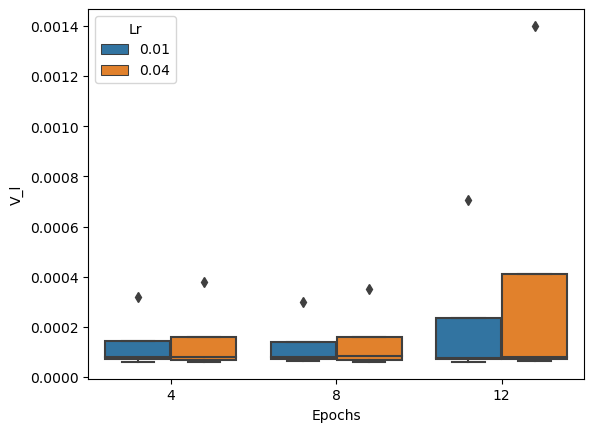

In [61]:
f =  (results.Model_type == 0) & (results.Min_val == True)
sns.boxplot(y = "V_l",x="Epochs",data = results[f],hue = "Lr")
plt.savefig("Figures/Split_by_exec/Lr_effect_Testloss_fEpochs.png")

In [18]:
##Old loop

learning_rates = [0.0025*4**i for i in range(2)]
loss_fn = torch.nn.MSELoss()
nbs_e = [8]#,4,8]
i=0
nbs_hidden = [2,3]
dors = [0,0.05]#,0.1,0.2,0.4]
results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w_split_by_exec_nl"
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            for dor in dors:
                m = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
                m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
                optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)

                saved_models = dict()

                for mt in ["min_val","all_epochs"]:
                    path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"


                    model = m
                    m.load_state_dict(torch.load(path))
                    m.eval()

                    test_predictions = m(d_ft_in["test"].float())
                    test_loss = loss_fn(test_predictions.squeeze(),d_ft_out["test"])

                    train_predictions = m(d_ft_in["train"].float())
                    train_loss = loss_fn(train_predictions.squeeze(),d_ft_out["train"])

                    validation_prediction = m(d_ft_in["val"].float())
                    validation_loss = loss_fn(validation_prediction.squeeze(),d_ft_out["val"])

                    if mt == "min_val": 
                        min_val = True
                    else: 
                        min_val = False

                    r = pd.DataFrame({"Model_type": nb_hidden,
                                      "Min_val":min_val,
                                      "Epochs": nb_e,
                                      "Lr":lr,
                                      "Dor": dor,
                                      "Tr_l":train_loss.item(),
                                      "Te_l":test_loss.item(),
                                      "V_l": validation_loss.item()}
                                     ,index = [i]
                    )
                    i+=1
                    results = pd.concat([results,r])

ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0 2 False
EPOCH 1:
  batch 1 loss: 0.00034164607524871826
  batch 101 loss: 0.0002987160199381833
LOSS train 0.00046863495772977727 valid 6.615156962652691e-06
EPOCH 2:
  batch 1 loss: 1.1388824532332364e-07
  batch 101 loss: 4.279915004374857e-06
LOSS train 3.882639331988874e-06 valid 4.274984803487314e-06
EPOCH 3:
  batch 1 loss: 4.7142380026343745e-08
  batch 101 loss: 4.714095463782542e-06
LOSS train 4.845918405521013e-06 valid 8.368496310140472e-06
EPOCH 4:
  batch 1 loss: 2.067415334749967e-07
  batch 101 loss: 9.704118892841507e-06
LOSS train 9.098841420518179e-06 valid 1.0499067684577312e-05
EPOCH 5:
  batch 1 loss: 2.2910639017936775e-07
  batch 101 loss: 8.047440166905062e-06
LOSS train 7.632

  batch 101 loss: 8.349045927786846e-05
LOSS train 8.473249215222182e-05 valid 0.00026572568458504975
EPOCH 4:
  batch 1 loss: 1.0685541201382875e-06
  batch 101 loss: 8.358249860577871e-05
LOSS train 8.481747875356945e-05 valid 0.00026821994106285274
EPOCH 5:
  batch 1 loss: 1.0860618931474164e-06
  batch 101 loss: 8.359412293373224e-05
LOSS train 8.482635637699415e-05 valid 0.00026957711088471115
EPOCH 6:
  batch 1 loss: 1.0956062033073977e-06
  batch 101 loss: 8.419897172757374e-05
LOSS train 8.527024099659193e-05 valid 0.00027045802562497556
EPOCH 7:
  batch 1 loss: 1.1018083023373038e-06
  batch 101 loss: 8.358560233659773e-05
LOSS train 8.481361840040336e-05 valid 0.00027101245359517634
EPOCH 8:
  batch 1 loss: 1.1057133815484121e-06
  batch 101 loss: 8.357661963202645e-05
LOSS train 8.480413396891824e-05 valid 0.00027139612939208746
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features